# Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
import itertools
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20, 10

# Data collection (Data acquisition)

In [27]:
start_date = '1980-01-01'
end_date = '2019-12-31'
stocks = data.DataReader('AAPL', 'yahoo', start_date, end_date)
stocks

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.406782
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.385558
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.357260
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.366103
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.376715
...,...,...,...,...,...,...
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831


# Data preprocessing

## Handling NA values

In [28]:
print(len(stocks))
stocks = stocks.dropna()
print(len(stocks))

9846
9846


# Feature engineering

## Generate time series data

In [29]:
time_series = stocks['Close']
time_series

Date
1980-12-12      0.513393
1980-12-15      0.486607
1980-12-16      0.450893
1980-12-17      0.462054
1980-12-18      0.475446
                 ...    
2019-12-24    284.269989
2019-12-26    289.910004
2019-12-27    289.799988
2019-12-30    291.519989
2019-12-31    293.649994
Name: Close, Length: 9846, dtype: float64

## Visualizing time series data

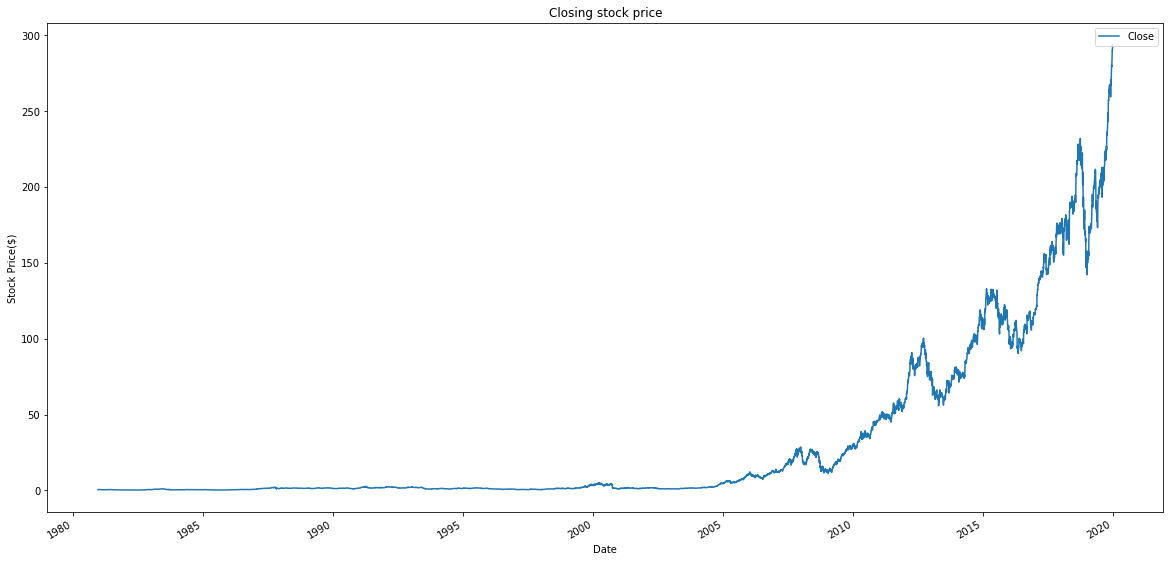

In [30]:
time_series.plot(figsize=(20, 10))
plt.title('Closing stock price')
plt.ylabel('Stock Price($)')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.show()

## Time-series object and windowing technique

In [31]:
time_series.index
shifted_window_size = 30

# Detecting stationarity in time series data (https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)

## Rolling (moving) statistics (additive time series and multiplicative time series)

In [32]:
def rolling_statistics(time_series):
    print ('Results of Rolling (moving) statistics Test:')
    rolling_mean = time_series.rolling(window = shifted_window_size).mean()
    rolling_std = time_series.rolling(window = shifted_window_size).std()
    plt.plot(time_series, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()

Results of Rolling (moving) statistics Test:


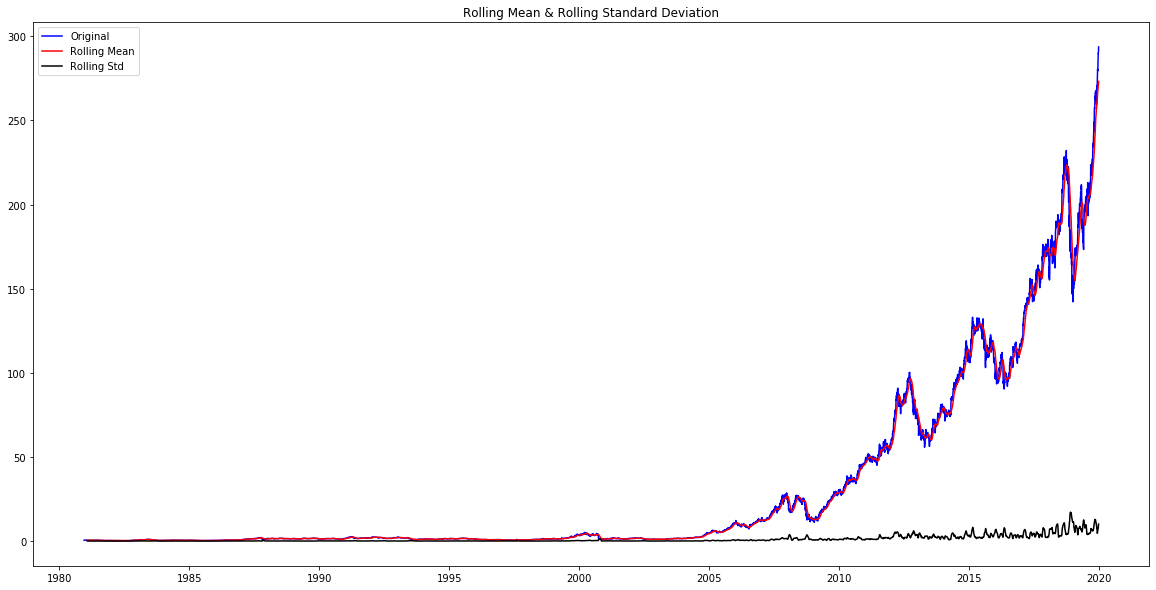

In [33]:
rolling_statistics(time_series)

## Augmented Dickey Fuller Test (ADF) (additive time series)

In [34]:
def adf_test(time_series):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [35]:
adf_test(time_series)

Results of Dickey-Fuller Test:
Test Statistic                    4.485185
p-value                           1.000000
#Lags Used                       37.000000
Number of Observations Used    9808.000000
Critical Value (1%)              -3.431017
Critical Value (5%)              -2.861835
Critical Value (10%)             -2.566927
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin Test (KPSS) (multiplicative time series)

In [36]:
def kpss_test(time_series):
    print ('Results of Kwiatkowski–Phillips–Schmidt–Shin Test:')
    dftest = kpss(time_series, 'ct')
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value','Number of Observations Used'])
    for key,value in dftest[3].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    


In [37]:
kpss_test(time_series)

Results of Kwiatkowski–Phillips–Schmidt–Shin Test:
Test Statistic                  4.841487
p-value                         0.010000
Number of Observations Used    38.000000
Critical Value (10%)            0.119000
Critical Value (5%)             0.146000
Critical Value (2.5%)           0.176000
Critical Value (1%)             0.216000
dtype: float64


# Making the time series stationary (https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima)

## Differencing (finding parameter d in ARIMA model)

In [38]:
ts_log = np.log(time_series)
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
adf_test(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -22.583706
p-value                           0.000000
#Lags Used                       16.000000
Number of Observations Used    9828.000000
Critical Value (1%)              -3.431016
Critical Value (5%)              -2.861834
Critical Value (10%)             -2.566927
dtype: float64


## Decomposition

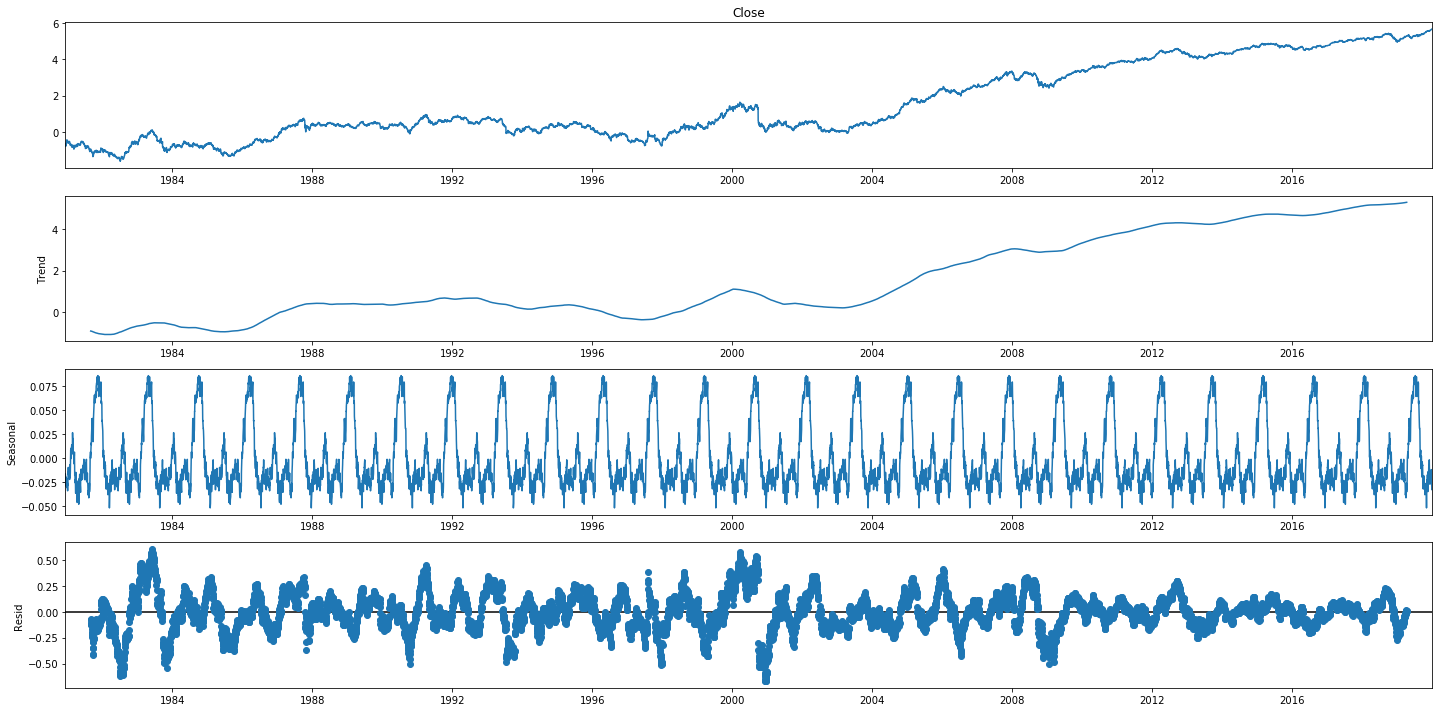

In [39]:
decomposition = sm.tsa.seasonal_decompose(ts_log, model='additive',period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
plt.show()

In [40]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
adf_test(ts_log_decompose)

Results of Dickey-Fuller Test:
Test Statistic                -8.883203e+00
p-value                        1.301060e-14
#Lags Used                     1.700000e+01
Number of Observations Used    9.464000e+03
Critical Value (1%)           -3.431041e+00
Critical Value (5%)           -2.861845e+00
Critical Value (10%)          -2.566933e+00
dtype: float64


# Partial auto correlation function (PACF) and Auto correlation function (ACF) (finding parameter p and q in ARIMA model) (https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima)

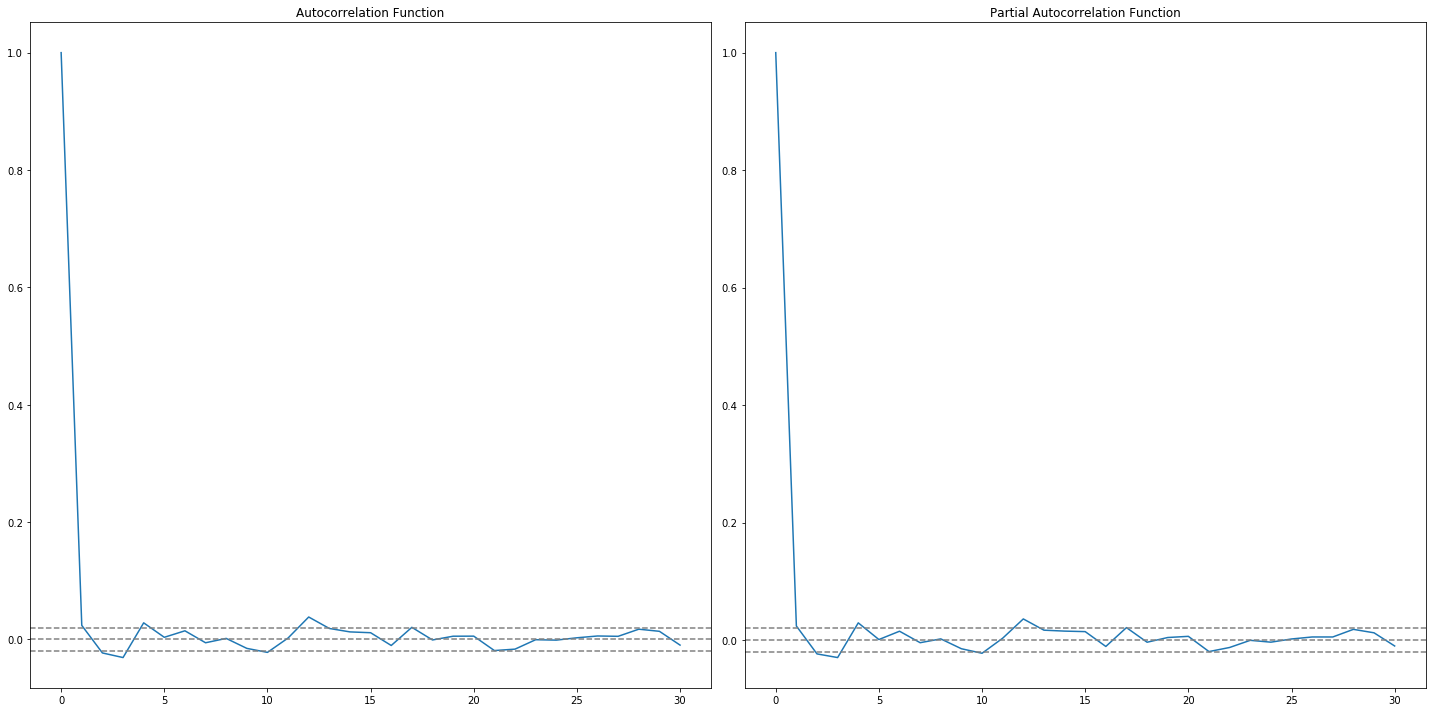

In [41]:
lag_acf = acf(ts_log_diff, nlags=shifted_window_size)
lag_pacf = pacf(ts_log_diff, nlags=shifted_window_size, method='ols')
#Normal distribution (mean=0,std=1)
#Confidence intervals (CI) -------> Z* score
#99%--->2.576
#98%--->2.326
#95%--->1.96
#90%--->1.645
#lower bound: mean-Z*(std/sqrt(sample_size)) = 0-Z*(1/sqrt(sample_size)) = -Z*/sqrt(sample_size)
#upper bound: mean+Z*(std/sqrt(sample_size)) = 0+Z*(1/sqrt(sample_size)) =  Z*/sqrt(sample_size)



#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

# Grid search (https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)

In [25]:
#tuning ARIMA hyperparameters using grid search method
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    #train:validation:test=80%:10%:10%
    train_size = int(len(X) * 0.8)
    validation_size = int(len(X) * 0.1)
    test_size = int(len(X) * 0.1)
    train, validation, test = X[0:train_size], X[train_size:(train_size+validation_size)], X[(train_size+validation_size):]
    history = [x for x in train]
    # make predictions
    predictions = list()
    #tuning ARIMA hyperparameters using grid search method double check validation & test
    #for t in range(len(validation)):
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        #tuning ARIMA hyperparameters using grid search method double check validation & test
        #history.append(validation[t])
        history.append(test[t])
    # calculate out of sample error
    #tuning ARIMA hyperparameters using grid search method double check validation & test
    #error = mean_squared_error(validation, predictions)
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    pdq = list(itertools.product(p_values, d_values, q_values))
    for x in pdq:
        print('p=',x[0],'d=',x[1],'q=',x[2])
        order = (x[0],x[1],x[2])
        try:
            mse = evaluate_arima_model(dataset, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
                print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
            continue

    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))



p_values = range(0,2)
d_values = [1]
q_values = range(0,2)
evaluate_models(time_series, p_values, d_values, q_values)

p= 0 d= 1 q= 0
ARIMA(0, 1, 0) MSE=7.039
p= 0 d= 1 q= 1
p= 1 d= 1 q= 0
p= 1 d= 1 q= 1
Best ARIMA(0, 1, 0) MSE=7.039


# AR Model (https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima)

Plotting AR model


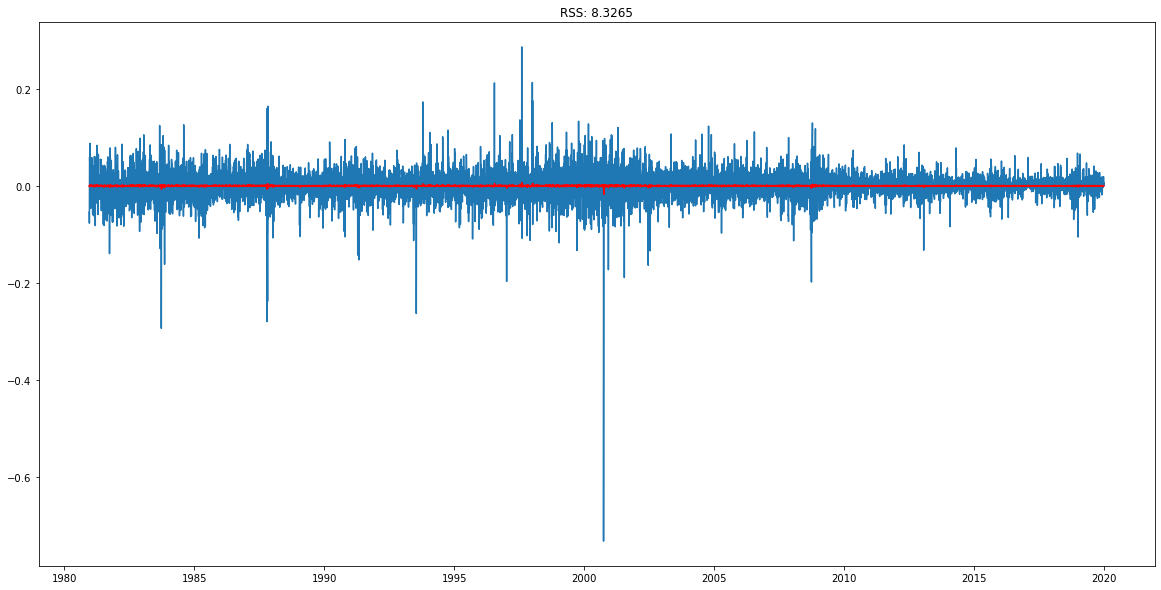

In [42]:
model = ARIMA(ts_log, order=(1,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - ts_log_diff)**2))
print('Plotting AR model')

# MA Model (https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima)

Plotting MA model


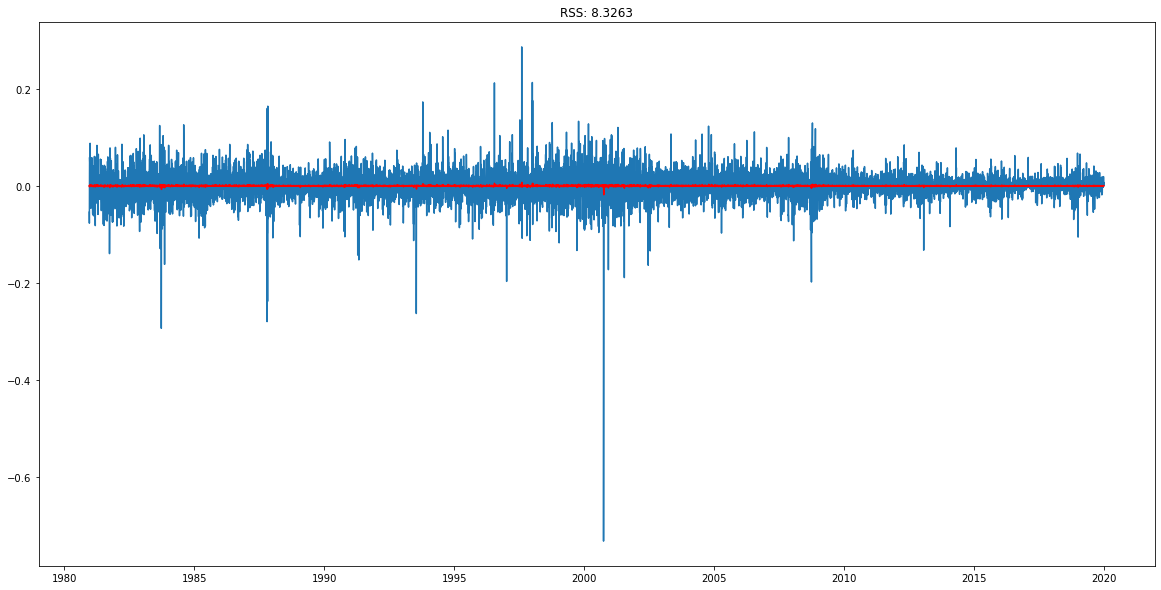

In [43]:
model = ARIMA(ts_log, order=(0,1,1))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - ts_log_diff)**2))
print('Plotting MA model')

# ARIMA model (https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima)

Plotting ARIMA model


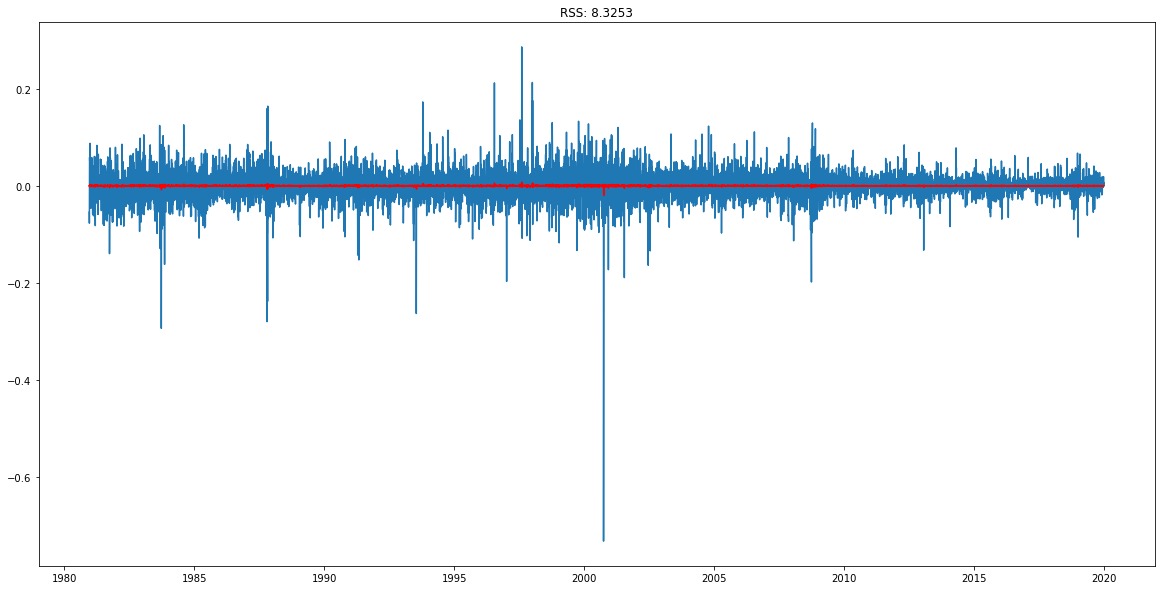

In [44]:
model = ARIMA(ts_log, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - ts_log_diff)**2))
print('Plotting ARIMA model')

# ARIMA evaluation (https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)

Text(0.5, 1.0, 'RMSE: 22.5833')

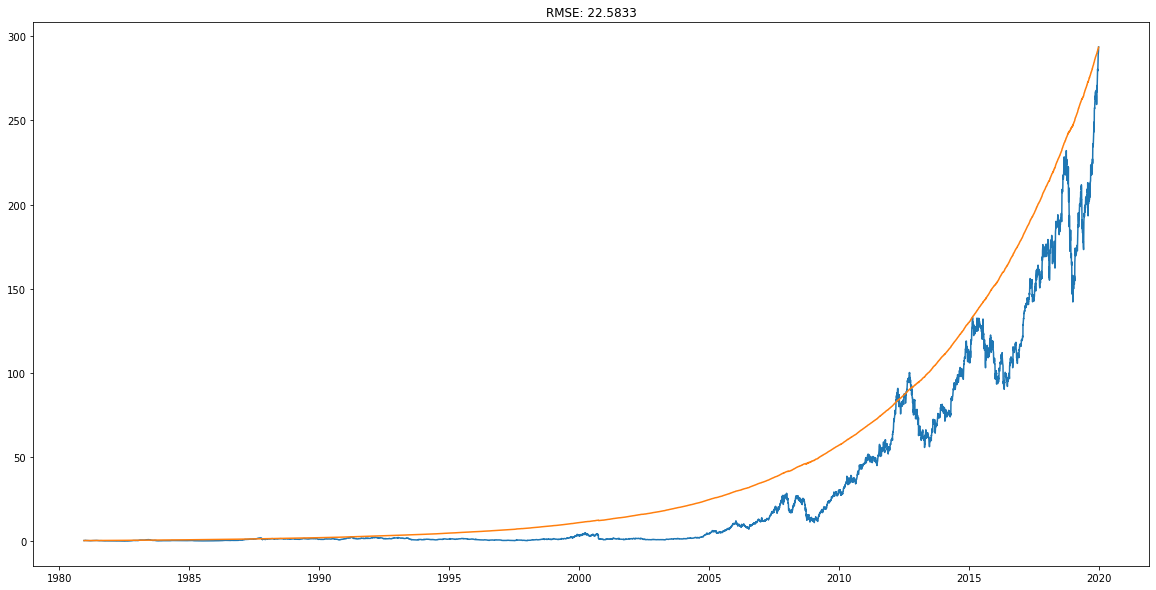

In [46]:
#make time series from diff predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#inverse operations:
#differencing and cumulative sum
#log and exp

#differencing example:
#time_series =  1 2 3 4 5
#differencing   - 1 2 3 4
#-------------------------
#shifted_ts  =    1 1 1 1

#cumulative sum example:
#shifted_ts  =    1 1 1 1
#cumsum         + 0 1 2 3
#-------------------------
#time_series =    1 2 3 4


#make cumsum predictions from diff predictions(The inverse operation of diff is cumsum) diff--->cumsum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#use ts_log for time series format 
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
#make log time series from cumsum predictions cumsum--->ts_log
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()
#(The inverse operation of log is exp) ts_log--->ts
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(time_series)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'%np.sqrt(sum((predictions_ARIMA - time_series)**2)/len(time_series)))

# Long short-term memory (LSTM)

## Train Validation Test split (https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

In [47]:
#train:validation:test=80%:10%:10%
dataset = time_series
dataset = dataset.values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
validation_size = int(len(dataset) * 0.10)
test_size = int(len(dataset) * 0.10)
train, validation, test = dataset[0:train_size,:], dataset[train_size:(train_size+validation_size),:], dataset[(train_size+validation_size):len(dataset),:]

## Sliding Window Technique (https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

In [48]:
def create_dataset(dataset, shifted_window_size):
    X, Y = [], []
    for i in range(len(dataset)-shifted_window_size-1):
        a = dataset[i:(i+shifted_window_size), 0]
        X.append(a)
        Y.append(dataset[i + shifted_window_size, 0])
    return np.array(X), np.array(Y)
    

X_train, Y_train = create_dataset(train, shifted_window_size)
X_validation, Y_validation = create_dataset(validation, shifted_window_size)
X_test, Y_test = create_dataset(test, shifted_window_size)

# reshape input to be [samples, time steps=shifted_window_size, features]
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_validation = np.reshape(X_validation, (X_validation.shape[0],X_validation.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))



## Build, compile  train LSTM (https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/)

In [49]:
#tuning LSTM hyperparameters using trial and error method
model = Sequential()
model.add(LSTM(100, input_shape=(shifted_window_size,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#tuning LSTM hyperparameters using trial and error method
#history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_validation, Y_validation), 
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

#final model after hyperparameters have been tuned
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()




Train on 7845 samples, validate on 955 samples
Epoch 1/20
7845/7845 [==============================] - 13s 2ms/step - loss: 2.4052e-04 - val_loss: 0.0201
Epoch 2/20
7845/7845 [==============================] - 6s 817us/step - loss: 6.4507e-04 - val_loss: 0.0386
Epoch 3/20
7845/7845 [==============================] - 4s 517us/step - loss: 6.7227e-04 - val_loss: 0.0466
Epoch 4/20
7845/7845 [==============================] - 4s 547us/step - loss: 7.8735e-04 - val_loss: 0.0091
Epoch 5/20
7845/7845 [==============================] - 4s 527us/step - loss: 9.1504e-04 - val_loss: 0.0244
Epoch 6/20
7845/7845 [==============================] - 4s 551us/step - loss: 7.4897e-04 - val_loss: 0.0182
Epoch 7/20
7845/7845 [==============================] - 4s 541us/step - loss: 3.4257e-04 - val_loss: 0.0031
Epoch 8/20
7845/7845 [==============================] - 4s 533us/step - loss: 6.2181e-05 - val_loss: 0.0213
Epoch 9/20
7845/7845 [==============================] - 4s 544us/step - loss: 3.5404e-05 -

# LSTM evaluation (https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

In [50]:
train_predict = model.predict(X_train)
#tuning LSTM hyperparameters using trial and error method
#validation_predict = model.predict(X_validation)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
#tuning LSTM hyperparameters using trial and error method
#validation_predict = scaler.inverse_transform(validation_predict)
#Y_validation = scaler.inverse_transform([Y_validation])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
#tuning LSTM hyperparameters using trial and error method
#print('Validation Mean Absolute Error:', mean_absolute_error(Y_validation[0], validation_predict[:,0]))
#print('Validation Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_validation[0], validation_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1.9585484709731535
Train Root Mean Squared Error: 1.9902440538773785
Test Mean Absolute Error: 17.12731775413633
Test Root Mean Squared Error: 20.818380062895873


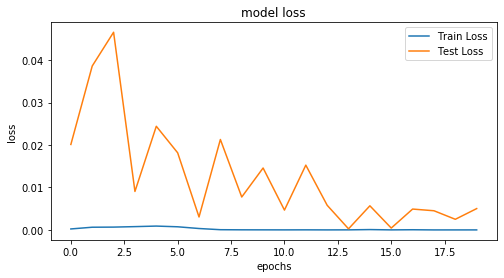

In [51]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
#tuning LSTM hyperparameters using trial and error method
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Making Predictions (https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

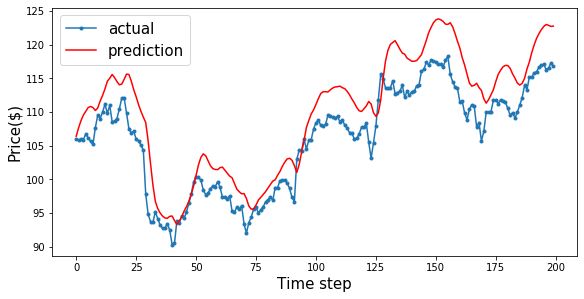

In [52]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Price($)', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();